In [1]:
# import zipfile
# with zipfile.ZipFile("/home/mira1/vlex_mira/acad/three_class_new.zip", 'r') as zip_ref:
#     zip_ref.extractall("/home/mira1/vlex_mira/acad/data_processed2")
# import tarfile
# with tarfile.open("/home/mira1/vlex_mira/acad/binary.tar.gz", "r:gz") as tar:
#     tar.extractall("/home/mira1/vlex_mira/acad/data_processed2/")

In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pdc
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim


from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter
this_path = Path().resolve()

In [2]:
binary_data = this_path.parent.parent/'data_processed/binary/'
models_path = this_path.parent.parent/'models/binary/'


In [3]:
experiment_no = 'test'
network_arch = 'swin_t'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : binary_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 90,
        'batch_size' : 16,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'milestones': [21, 30, 40],
        'sch_patience': 7,
        'sch_thresh': 0.01,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:1',
        'optimizer': 'adam',
        'parallel': False,
        },
    'val': {
        'batch_size' : 15,
        'num_workers' : 2,
        }
}

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0, 70), interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.RandomEqualize(),
        # transforms.RandomAffine(degrees=(-30,30), translate=(0.1, 0.2), scale=(0.95, 1.2)),
        transforms.ColorJitter(brightness=0.1, hue=0.1),
        transforms.GaussianBlur(kernel_size=(3,9)),
        transforms.ToTensor(),
        transforms.Normalize([0.6554, 0.5311, 0.5245], [0.2349, 0.2130, 0.2234])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.6554, 0.5311, 0.5245], [0.2349, 0.2130, 0.2234])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms[x])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"


In [5]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=True),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=True)
    }

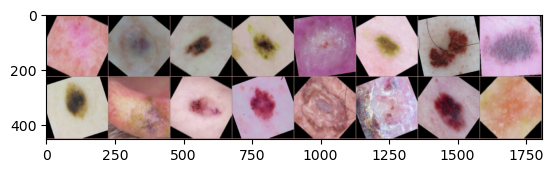

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6554, 0.5311, 0.5245])
    std = np.array([0.2349, 0.2130, 0.2234])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

### Train model

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
def train_model(model, criterion, optimizer, scheduler, writer, early_stopper, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    last_three_losses = []
    early_stopping_count = 0
    previous_mean_loss = 0


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]

            # if phase == 'val':
            #     scheduler.step(epoch_loss)
            #     # print(f"Last LR: {optimizer.param_groups[0]['lr']} --- ")

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalars('acc',{f'{phase}': epoch_acc}, epoch+1)
            writer.add_scalars('loss',{f'{phase}': epoch_loss}, epoch+1)

            # save last and best checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'configuration': cfg,
                'loss': epoch_loss}, cfg['data']['chkpt_path']/f'last_checkpoint_{epoch}.pt')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                best_metric = best_acc
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metric,
                    'configuration': cfg
                    }, cfg['data']['best_model_path'])

        if phase == 'val':
            if early_stopper.early_stop(epoch_loss):
                print(f'Training stopped at epoch {epoch}')             
                break
                
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

### SWIN_T and swin_v2_t

In [8]:
model_ft = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.head.in_features
# model_ft.head = nn.Linear(num_ftrs, 2)
model_ft.head = nn.Sequential(
                        nn.Linear(num_ftrs, 512),
                        nn.ReLU(),
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 2)
                        )
if cfg['train']['parallel']:                        
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model_ft = nn.DataParallel(model_ft, device_ids = [1, 0])
    else:
        print("Data paralellism not possible")
        
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

if cfg['train']['optimizer'] == 'adam':
    optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
else:
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

if cfg['train']['milestones'] is not None:
    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer_ft, milestones=cfg['train']['milestones'], gamma=cfg['train']['gamma'])
else:
    exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                             

# count_parameters(model_ft)

In [9]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
print(logdir)
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

/home/mira1/vlex_mira/acad/models/binary/tensorboard/swin_t/exp15-4-3-im512-e1-3
Epoch 0/89
----------
train Loss: 0.5015 Acc: 0.7582
val Loss: 0.4177 Acc: 0.8214

Epoch 1/89
----------
train Loss: 0.4345 Acc: 0.8058
val Loss: 0.3870 Acc: 0.8272

Epoch 2/89
----------
train Loss: 0.4122 Acc: 0.8180
val Loss: 0.3814 Acc: 0.8343

Epoch 3/89
----------
train Loss: 0.4011 Acc: 0.8200
val Loss: 0.3907 Acc: 0.8127

Epoch 4/89
----------
train Loss: 0.3892 Acc: 0.8270
val Loss: 0.4222 Acc: 0.8164

Epoch 5/89
----------
train Loss: 0.3804 Acc: 0.8319
val Loss: 0.3687 Acc: 0.8375

Epoch 6/89
----------
train Loss: 0.3765 Acc: 0.8365
val Loss: 0.3341 Acc: 0.8630

Epoch 7/89
----------
train Loss: 0.3677 Acc: 0.8413
val Loss: 0.3335 Acc: 0.8564

Epoch 8/89
----------
train Loss: 0.3645 Acc: 0.8399
val Loss: 0.3451 Acc: 0.8601

Epoch 9/89
----------
train Loss: 0.3642 Acc: 0.8415
val Loss: 0.3350 Acc: 0.8641

Epoch 10/89
----------
train Loss: 0.3552 Acc: 0.8440
val Loss: 0.3584 Acc: 0.8485

Epoch

KeyboardInterrupt: 

In [21]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [22]:
cfg['data']['chkpt_path']/f'last_checkpoint_49.pt'

PosixPath('/home/mira1/vlex_mira/acad/models/binary/swin_t/exp15-5/last_checkpoint_49.pt')

In [25]:
# resume training

experiment_no = 'exp15-5_2'
network_arch = 'swin_t'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : binary_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 50,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'sch_patience': 7,
        'sch_thresh': 0.001,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:0',
        },
    'val': {
        'batch_size' : 25,
        'num_workers' : 2,
        }
}

model_ft_new = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
num_ftrs = model_ft_new.head.in_features
model_ft_new.head = nn.Linear(num_ftrs, 2)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft_new = model_ft_new.to(device)
criterion_new = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft_new = optim.SGD(model_ft_new.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])
exp_lr_scheduler_new = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft_new, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                                

model_ft_new, optimizer_ft_new, start_epoch = load_checkpoint(model_ft_new,
                                                                optimizer_ft_new,
                                                                '/home/mira1/vlex_mira/acad/models/binary/swin_t/exp15-5/last_checkpoint_49.pt')

=> loading checkpoint '/home/mira1/vlex_mira/acad/models/binary/swin_t/exp15-5/last_checkpoint_49.pt'
=> loaded checkpoint '/home/mira1/vlex_mira/acad/models/binary/swin_t/exp15-5/last_checkpoint_49.pt' (epoch 49)


In [26]:

logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft_new, criterion_new, optimizer_ft_new, exp_lr_scheduler_new, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/49
----------
train Loss: 0.2144 Acc: 0.9075
val Loss: 0.2977 Acc: 0.8691

Epoch 1/49
----------
train Loss: 0.2143 Acc: 0.9092
val Loss: 0.3002 Acc: 0.8709

Epoch 2/49
----------
train Loss: 0.2146 Acc: 0.9097
val Loss: 0.2982 Acc: 0.8714

Epoch 3/49
----------
train Loss: 0.2126 Acc: 0.9099
val Loss: 0.2978 Acc: 0.8704

Epoch 4/49
----------
train Loss: 0.2131 Acc: 0.9109
val Loss: 0.2979 Acc: 0.8712

Epoch 5/49
----------
train Loss: 0.2116 Acc: 0.9088
val Loss: 0.2981 Acc: 0.8707

Epoch 6/49
----------
train Loss: 0.2159 Acc: 0.9085
val Loss: 0.2992 Acc: 0.8699

Epoch 7/49
----------
train Loss: 0.2138 Acc: 0.9089
val Loss: 0.2982 Acc: 0.8709

Epoch 8/49
----------
train Loss: 0.2115 Acc: 0.9113
Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
val Loss: 0.2987 Acc: 0.8696

Epoch 9/49
----------
train Loss: 0.2101 Acc: 0.9115
val Loss: 0.2987 Acc: 0.8693

Epoch 10/49
----------
train Loss: 0.2110 Acc: 0.9116
val Loss: 0.2986 Acc: 0.8707

Epoch 11/49
----------
t

KeyboardInterrupt: 

### Resnet50

In [8]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])
count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

25561130

In [ ]:
# print model's layers to have an idea of the layers

# [module for module in model_ft.modules() if not isinstance(module, nn.Sequential)]
# dict(model_ft.named_modules())
for child in model_ft.children():
    print(child)

In [9]:
# freezing some initial layers
ct = 0
for child in model_ft.children():
    ct += 1
    if ct <= 6:
        for param in child.parameters():
            param.requires_grad = False

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer3.0.conv1.weight     |   131072   |
|     layer3.0.bn1.weight      |    256     |
|      layer3.0.bn1.bias       |    256     |
|    layer3.0.conv2.weight     |   589824   |
|     layer3.0.bn2.weight      |    256     |
|      layer3.0.bn2.bias       |    256     |
|    layer3.0.conv3.weight     |   262144   |
|     layer3.0.bn3.weight      |    1024    |
|      layer3.0.bn3.bias       |    1024    |
| layer3.0.downsample.0.weight |   524288   |
| layer3.0.downsample.1.weight |    1024    |
|  layer3.0.downsample.1.bias  |    1024    |
|    layer3.1.conv1.weight     |   262144   |
|     layer3.1.bn1.weight      |    256     |
|      layer3.1.bn1.bias       |    256     |
|    layer3.1.conv2.weight     |   589824   |
|     layer3.1.bn2.weight      |    256     |
|      layer3.1.bn2.bias       |    256     |
|    layer3.1.conv3.weight     |  

24116202

In [10]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=5, min_delta=0.002)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/29
----------
train Loss: 1.2783 Acc: 0.6918
val Loss: 0.4474 Acc: 0.8109

Epoch 1/29
----------
train Loss: 0.4010 Acc: 0.8190
val Loss: 0.4114 Acc: 0.8190

Epoch 2/29
----------
train Loss: 0.3753 Acc: 0.8334
val Loss: 0.3980 Acc: 0.8219

Epoch 3/29
----------
train Loss: 0.3519 Acc: 0.8411
val Loss: 0.3825 Acc: 0.8293

Epoch 4/29
----------
train Loss: 0.3392 Acc: 0.8507
val Loss: 0.3736 Acc: 0.8325

Epoch 5/29
----------
train Loss: 0.3260 Acc: 0.8551
val Loss: 0.3725 Acc: 0.8317

Epoch 6/29
----------
train Loss: 0.3191 Acc: 0.8578
val Loss: 0.3748 Acc: 0.8309

Epoch 7/29
----------
train Loss: 0.3205 Acc: 0.8545
val Loss: 0.3706 Acc: 0.8319

Epoch 8/29
----------
train Loss: 0.3202 Acc: 0.8592
val Loss: 0.3703 Acc: 0.8311

Epoch 9/29
----------
train Loss: 0.3204 Acc: 0.8588
val Loss: 0.3691 Acc: 0.8306

Epoch 10/29
----------
train Loss: 0.3188 Acc: 0.8589
val Loss: 0.3695 Acc: 0.8317

Epoch 11/29
----------
train Loss: 0.3182 Acc: 0.8605
val Loss: 0.3715 Acc: 0.8319

Ep

### Inception Resnet V2

In [8]:
model_ft = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])


In [9]:
logdir = cfg['data']['tensorboard_path']/'inception_resnet_v2/exp3'
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=3, min_delta=10)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/29
----------
train Loss: 0.4138 Acc: 0.8099
val Loss: 0.3909 Acc: 0.8280

Epoch 1/29
----------
train Loss: 0.3586 Acc: 0.8382
val Loss: 0.3640 Acc: 0.8375

Epoch 2/29
----------
train Loss: 0.3382 Acc: 0.8546
val Loss: 0.3527 Acc: 0.8419

Epoch 3/29
----------
train Loss: 0.3220 Acc: 0.8564
val Loss: 0.4213 Acc: 0.8159

Epoch 4/29
----------
train Loss: 0.3087 Acc: 0.8627
val Loss: 0.3348 Acc: 0.8459

Epoch 5/29
----------
train Loss: 0.2545 Acc: 0.8917
val Loss: 0.3107 Acc: 0.8606

Epoch 6/29
----------
train Loss: 0.2351 Acc: 0.9029
val Loss: 0.3067 Acc: 0.8654

Epoch 7/29
----------
train Loss: 0.2226 Acc: 0.9094
val Loss: 0.3036 Acc: 0.8680

Epoch 8/29
----------
train Loss: 0.2092 Acc: 0.9119
val Loss: 0.3041 Acc: 0.8714

Epoch 9/29
----------
train Loss: 0.1989 Acc: 0.9162
val Loss: 0.3052 Acc: 0.8688

Epoch 10/29
----------
train Loss: 0.1850 Acc: 0.9227
val Loss: 0.3046 Acc: 0.8746

Epoch 11/29
----------
train Loss: 0.1797 Acc: 0.9267
val Loss: 0.3067 Acc: 0.8730

Ep